In [1]:
import os
import sys
import warnings
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th
import pickle
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from scripts.utils import (
    load_scenario_data,
    verify_training_folders,
    create_results_directory,
    get_model_version,
    format_days,
    calculate_training_days,
    initialize_device,
    check_device_capabilities,
    get_device_info,
)
from scripts.visualizations import *
from src.config import *
from sb3_contrib import MaskablePPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.common.wrappers import ActionMasker
from src.environment import AircraftDisruptionEnv
from sb3_contrib.common.maskable.utils import get_action_masks
import seaborn as sns
sns.set(style="darkgrid", font_scale=1.5)


# In train_dqn_both_timesteps.ipynb:
if 'MAX_TOTAL_TIMESTEPS' not in globals():
    MAX_TOTAL_TIMESTEPS = 1000000
if 'TRAINING_FOLDERS_PATH' not in globals():
    TRAINING_FOLDERS_PATH = "../data/Training/3ac-100-mixed/"
if 'SEEDS' not in globals():
    SEEDS = [0, 1, 2]
if 'brute_force_flag' not in globals():
    brute_force_flag = False





LEARNING_RATE = 2.5e-4
GAMMA = 0.99
BATCH_SIZE = 64
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4
N_STEPS = 2048



# calculate how many folders are in the training folder
num_folders = len([f for f in os.listdir(TRAINING_FOLDERS_PATH) if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, f))])
print(f"Training on {num_folders} scenarios")

device = initialize_device()
stripped_scenario_folder = TRAINING_FOLDERS_PATH.split("/")[-2]
print(f"Training on {stripped_scenario_folder}")

num_days_trained_on = 10
formatted_days = format_days(num_days_trained_on)
model_name = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))
MODEL_SAVE_PATH = '../trained_models/ppo/'
MODEL_SAVE_NAME_MYOPIC = f'{model_name}-{formatted_days}-{get_model_version(model_name, "myopic", "ppo")}.zip'
MODEL_SAVE_NAME_PROACTIVE = f'{model_name}-{formatted_days}-{get_model_version(model_name, "proactive", "ppo")}.zip'
print(f"Models will be saved to:\n   {MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME_MYOPIC}\n   {MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME_PROACTIVE}")

results_dir = create_results_directory(append_to_name='ppo')
print(f"Results directory created at: {results_dir}")

# Store episode-level rewards
episode_rewards_myopic = []
episode_rewards_proactive = []
episode_steps_myopic = []
episode_steps_proactive = []

def my_get_action_masks(env):
    mask = env.get_action_mask()
    mask = np.array(mask, dtype=np.uint8)
    return mask

def train_ppo_agent(env_type):
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]
    
    class ScenarioEnvWrapper(gym.Env):
        def __init__(self, scenario_folders, env_type):
            super(ScenarioEnvWrapper, self).__init__()
            self.scenario_folders = scenario_folders
            self.env_type = env_type
            self.current_scenario_idx = -1

            self.episode_scenario_rewards = []
            self.episode_count = 0
            
            # Track total environment steps
            self.total_env_steps = 0

            self.load_next_scenario()
            self.observation_space = self.env.observation_space
            self.action_space = self.env.action_space
            self.episode_reward = 0

        def load_next_scenario(self):
            self.current_scenario_idx = (self.current_scenario_idx + 1) % len(self.scenario_folders)
            scenario_folder = self.scenario_folders[self.current_scenario_idx]
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            self.env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=self.env_type
            )

        def reset(self, seed=None, options=None):
            # If not the first reset, we finished one scenario
            if self.episode_reward != 0:
                self.episode_scenario_rewards.append(self.episode_reward)
                self.episode_reward = 0

            # If we completed a full cycle of scenarios, one meta-episode is done
            if len(self.episode_scenario_rewards) == len(self.scenario_folders):
                total_episode_reward = sum(self.episode_scenario_rewards)
                # Record total steps and rewards depending on env_type
                if self.env_type == "myopic":
                    episode_rewards_myopic.append(total_episode_reward)
                    episode_steps_myopic.append(self.total_env_steps)
                else:
                    episode_rewards_proactive.append(total_episode_reward)
                    episode_steps_proactive.append(self.total_env_steps)

                # Reset for next meta-episode
                self.episode_scenario_rewards = []
                self.episode_count += 1

            self.load_next_scenario()
            obs, info = self.env.reset()
            return obs, info

        def step(self, action):
            obs, reward, done, truncated, info = self.env.step(action)
            self.episode_reward += reward
            self.total_env_steps += 1  # increment step counter each step
            return obs, reward, done, truncated, info

        def render(self, mode='human'):
            return self.env.render(mode=mode)

        def close(self):
            return self.env.close()

        def get_action_mask(self):
            return self.env.get_action_mask()

    env = ScenarioEnvWrapper(scenario_folders, env_type)
    env = ActionMasker(env, my_get_action_masks)
    env = DummyVecEnv([lambda: env])

    model = MaskablePPO(
        'MultiInputPolicy',
        env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        verbose=1,
        tensorboard_log=f"./ppo_aircraft_tensorboard_{env_type}/",
        device=device,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        n_steps=N_STEPS,
    )

    logger = configure()
    model.set_logger(logger)

    def log_rewards(_locals, _globals):
        # Here you can log episode metrics if needed.
        # The actual per-episode logging is done after training by
        # checking the global lists.
        return True

    # Run the training loop for a fixed number of timesteps
    model.learn(total_timesteps=MAX_TOTAL_TIMESTEPS, use_masking=True, callback=log_rewards)

    if env_type == "myopic":
        model.save(f"{MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME_MYOPIC}")
    else:
        model.save(f"{MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME_PROACTIVE}")

    return [], 0  # We return empty arrays here since we log after training

# start_time = datetime.now()
# results_myopic = train_ppo_agent('myopic')
# results_proactive = train_ppo_agent('proactive')
# rewards_myopic, total_timesteps_myopic = results_myopic
# rewards_proactive, total_timesteps_proactive = results_proactive

# Now, rewards_myopic and rewards_proactive are empty because we changed the logic.
# # The actual results are in episode_rewards_myopic and episode_rewards_proactive.

# myopic_rewards_file = os.path.join(results_dir, "episode_rewards_myopic.pkl")
# with open(myopic_rewards_file, "wb") as file:
#     pickle.dump(episode_rewards_myopic, file)
# print(f"Myopic episode-level rewards saved to {myopic_rewards_file}")

# proactive_rewards_file = os.path.join(results_dir, "episode_rewards_proactive.pkl")
# with open(proactive_rewards_file, "wb") as file:
#     pickle.dump(episode_rewards_proactive, file)
# print(f"Proactive episode-level rewards saved to {proactive_rewards_file}")

# end_time = datetime.now()
# runtime = (end_time - start_time).total_seconds()
# print(f"Total training time: {runtime} seconds")

# print("Myopic per-episode rewards:", episode_rewards_myopic)
# print("Proactive per-episode rewards:", episode_rewards_proactive)


Training on 100 scenarios
Using device: mps
Training on 3ac-100-mixed
Getting model version for 3ac-100-mixed
Getting model version for 3ac-100-mixed
Models will be saved to:
   ../trained_models/ppo/myopic_3ac-100-mixed-10-1.zip
   ../trained_models/ppo/proactive_3ac-100-mixed-10-1.zip
Results directory created at: ../results/ppo/20241207-11-12


In [2]:
import os
import numpy as np
import torch
import random

# Set the number of seeds

NUM_SEEDS = len(SEEDS)
# Prepare storage for multiple runs
all_myopic_runs = []
all_proactive_runs = []
all_myopic_steps_runs = []
all_proactive_steps_runs = []

def run_training_for_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    global episode_rewards_myopic, episode_rewards_proactive
    global episode_steps_myopic, episode_steps_proactive

    episode_rewards_myopic = []
    episode_rewards_proactive = []
    episode_steps_myopic = []
    episode_steps_proactive = []

    # Run the training
    train_ppo_agent('myopic')
    train_ppo_agent('proactive')

    return episode_rewards_myopic, episode_rewards_proactive, episode_steps_myopic, episode_steps_proactive

# Run training for each seed
for s in SEEDS:
    print(f"Running training for seed {s}...")
    myopic_rewards_seed, proactive_rewards_seed, myopic_steps_seed, proactive_steps_seed = run_training_for_seed(s)
    all_myopic_runs.append(myopic_rewards_seed)
    all_proactive_runs.append(proactive_rewards_seed)
    all_myopic_steps_runs.append(myopic_steps_seed)
    all_proactive_steps_runs.append(proactive_steps_seed)


min_length_myopic = min(len(run) for run in all_myopic_runs)
min_length_proactive = min(len(run) for run in all_proactive_runs)

all_myopic_runs = [run[:min_length_myopic] for run in all_myopic_runs]
all_proactive_runs = [run[:min_length_proactive] for run in all_proactive_runs]

all_myopic_steps_runs = [run[:min_length_myopic] for run in all_myopic_steps_runs]
all_proactive_steps_runs = [run[:min_length_proactive] for run in all_proactive_steps_runs]

all_myopic_runs = np.array(all_myopic_runs) / num_folders   
all_proactive_runs = np.array(all_proactive_runs) / num_folders

all_myopic_steps_runs = np.array(all_myopic_steps_runs)
all_proactive_steps_runs = np.array(all_proactive_steps_runs)

myopic_mean = all_myopic_runs.mean(axis=0)
myopic_std = all_myopic_runs.std(axis=0)

proactive_mean = all_proactive_runs.mean(axis=0)
proactive_std = all_proactive_runs.std(axis=0)

myopic_steps_mean = all_myopic_steps_runs.mean(axis=0).astype(int)
proactive_steps_mean = all_proactive_steps_runs.mean(axis=0).astype(int)


Running training for seed 0...
Using mps device
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-07-11-12-02-956784
-----------------------------
| time/              |      |
|    fps             | 158  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 140          |
|    iterations           | 2            |
|    time_elapsed         | 29           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0001711109 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.88        |
|    explained_variance   | -1.36e-05    |
|    learning_rate        | 0.00025      |
|    loss                 | 3.5e+07      |
|    n_updates            | 10           |
|    p

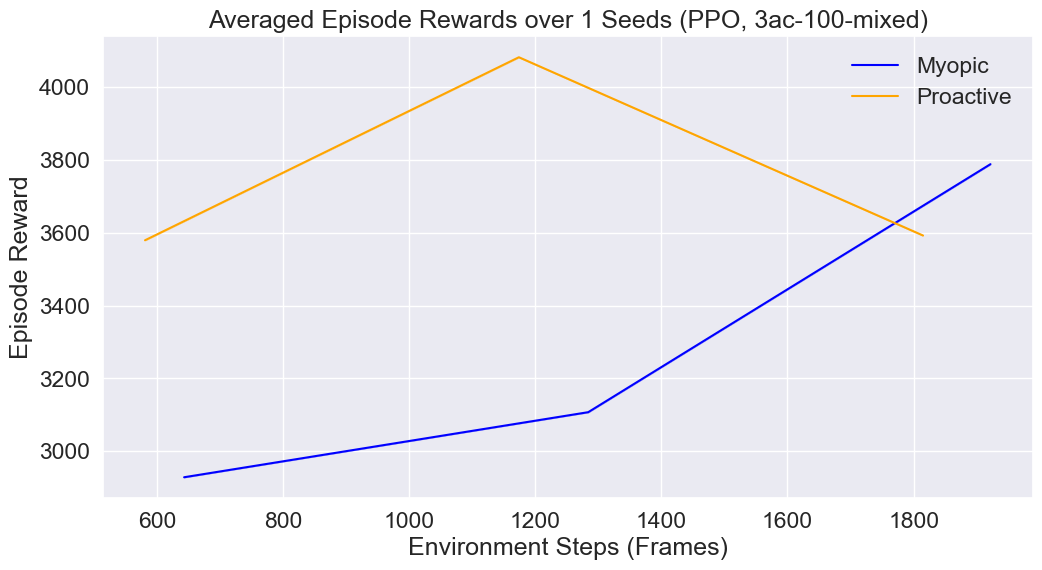

Averaged reward vs steps plot saved to ../results/ppo/20241207-02-59/averaged_rewards_over_steps.png


In [3]:
import matplotlib.pyplot as plt
# Plotting reward vs steps
plt.figure(figsize=(12,6))

# Set smoothing window
smooth_window = 25

def smooth(data, window):
    if window > 1 and len(data) >= window:
        return np.convolve(data, np.ones(window)/window, mode='valid')
    return data

myopic_mean_sm = smooth(myopic_mean, smooth_window)
myopic_std_sm = smooth(myopic_std, smooth_window)
myopic_steps_sm = myopic_steps_mean[:len(myopic_mean_sm)]

proactive_mean_sm = smooth(proactive_mean, smooth_window)
proactive_std_sm = smooth(proactive_std, smooth_window)
proactive_steps_sm = proactive_steps_mean[:len(proactive_mean_sm)]

plt.plot(myopic_steps_sm, myopic_mean_sm, label="Myopic", color='blue')
plt.fill_between(myopic_steps_sm, myopic_mean_sm - myopic_std_sm, myopic_mean_sm + myopic_std_sm, alpha=0.2, color='blue')

plt.plot(proactive_steps_sm, proactive_mean_sm, label="Proactive", color='orange')
plt.fill_between(proactive_steps_sm, proactive_mean_sm - proactive_std_sm, proactive_mean_sm + proactive_std_sm, alpha=0.2, color='orange')

plt.xlabel("Environment Steps (Frames)")
plt.ylabel("Episode Reward")
plt.title(f"Averaged Episode Rewards over {len(SEEDS)} Seeds (PPO, {stripped_scenario_folder})")
plt.legend(frameon=False)
plt.grid(True)

plot_file = os.path.join(results_dir, "averaged_rewards_over_steps.png")
plt.savefig(plot_file)
plt.show()
print(f"Averaged reward vs steps plot saved to {plot_file}")
